In [1]:
import torch
from segment_anything import sam_model_registry, SamPredictor
import numpy as np
from PIL import Image
import os

# 选用 MPS（Apple Silicon）或者回退 CPU
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Running on:", device)


Running on: mps


In [2]:
# Cell 2：加载 ViT-L 模型
from segment_anything import sam_model_registry, SamPredictor
import torch

device = "mps" if torch.backends.mps.is_available() else "cpu"

model_type = "vit_l"
checkpoint_path = "checkpoints/sam_vit_l_0b3195.pth"

sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to(device=device)
predictor = SamPredictor(sam)

print(f"Loaded {model_type} on {device}")


Loaded vit_l on mps


In [3]:
# Cell: Dependency installation
# （此处仅作提示，实际安装请在终端执行）
# 
# 在终端里运行：
#   pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
#   pip install git+https://github.com/facebookresearch/segment-anything.git
#   pip install jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0


In [1]:
# Cell: Colab Drive 挂载逻辑已移除
# 本地运行时，所有文件都在项目文件夹下
# 如果需要定义数据或模型路径，可以在这里设置：
BASE_DIR = "./"     # 项目根目录
DATA_DIR = BASE_DIR + "data/"       # 根据情况改成你的数据文件夹
CHECKPOINT_DIR = BASE_DIR + "checkpoints/"


In [2]:
# Cell: 本地路径配置
import os
from pathlib import Path

# 以当前工作目录作为项目根目录（请在 VSCode 里把工作目录切换到项目根）
BASE_DIR = Path().cwd()
print(f"Project root: {BASE_DIR}")

# 定义数据、权重、输出等目录
DATA_DIR       = BASE_DIR / "data"
CHECKPOINT_DIR = BASE_DIR / "checkpoints"
OUTPUT_DIR     = BASE_DIR / "outputs"
IMAGE_DIR      = BASE_DIR / "images"

# 自动创建（如果已存在则无影响）
for d in (DATA_DIR, CHECKPOINT_DIR, OUTPUT_DIR, IMAGE_DIR):
    d.mkdir(parents=True, exist_ok=True)
    print(f"Ensure directory: {d}")

# 示例：模型权重完整路径（请把 .pth 文件放到 checkpoints/ 下）
checkpoint_path = CHECKPOINT_DIR / "sam_vit_l_0b3195.pth"
print(f"Checkpoint path: {checkpoint_path}")


Project root: /Users/jeff/Desktop/SAM/segment-anything
Ensure directory: /Users/jeff/Desktop/SAM/segment-anything/data
Ensure directory: /Users/jeff/Desktop/SAM/segment-anything/checkpoints
Ensure directory: /Users/jeff/Desktop/SAM/segment-anything/outputs
Ensure directory: /Users/jeff/Desktop/SAM/segment-anything/images
Checkpoint path: /Users/jeff/Desktop/SAM/segment-anything/checkpoints/sam_vit_l_0b3195.pth


### 加载 SAM 模型并创建 Predictor


In [3]:
# Cell: Load SAM model & create predictor
import torch
from segment_anything import sam_model_registry, SamPredictor

# 选择设备：优先 MPS（Apple Silicon），否则 CPU
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

# 指定模型类型（vit_l / vit_h / vit_b）
model_type = "vit_l"
# 使用之前定义好的 checkpoint_path
sam = sam_model_registry[model_type](checkpoint=str(checkpoint_path))
sam.to(device=device)

# 创建预测器
predictor = SamPredictor(sam)
print(f"Loaded {model_type} model and created predictor")


Using device: mps
Loaded vit_l model and created predictor


### 对图像做分割并保存结果

deer.jpg → saved mask to deer_mask.png, score: 0.927


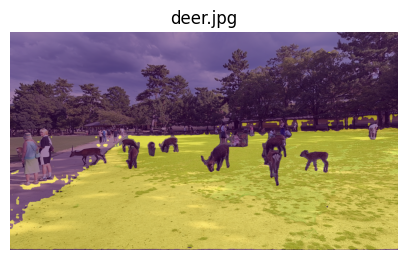

cat.jpg → saved mask to cat_mask.png, score: 0.976


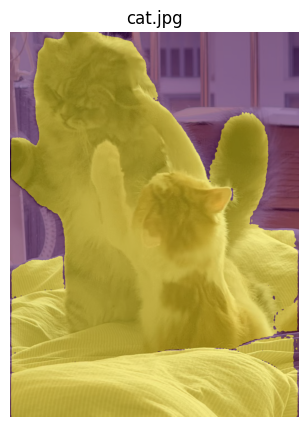

japan.jpg → saved mask to japan_mask.png, score: 0.797


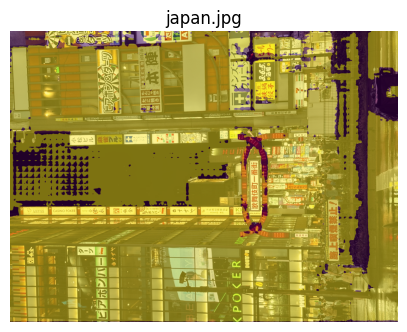

In [10]:
# Cell: Batch segmentation of all images in images/
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 遍历 images/ 文件夹下所有 jpg
for img_file in IMAGE_DIR.glob("*.jpg"):
    # 1) 读取并设置图像
    img = np.array(Image.open(img_file))
    predictor.set_image(img)

    # 2) 用整张图的 bbox 做一次分割
    h, w = img.shape[:2]
    box = np.array([[0, 0, w - 1, h - 1]])
    masks, scores, logits = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=box,
        multimask_output=False
    )

    # 3) 保存 mask
    mask = masks[0]  # bool 数组
    out_path = OUTPUT_DIR / f"{img_file.stem}_mask.png"
    Image.fromarray((mask * 255).astype(np.uint8)).save(out_path)
    print(f"{img_file.name} → saved mask to {out_path.name}, score: {scores[0]:.3f}")

    # 4) 在 Notebook 中可视化
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5)
    plt.axis("off")
    plt.title(img_file.name)
    plt.show()


### 用「点提示」做精细分割

/Users/jeff/Desktop/SAM/segment-anything/segment_anything/modeling/prompt_encoder.py:87: UserWarning: MPS: nonzero op is supported natively starting from macOS 14.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:404.)
  point_embedding[labels == -1] = 0.0


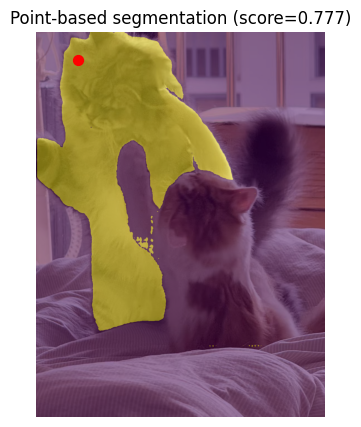

In [11]:
# Cell: Point-based segmentation example
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 1) 读取并设置图像（以 cat.jpg 为例）
img_file = IMAGE_DIR / "cat.jpg"
img = np.array(Image.open(img_file))
predictor.set_image(img)

# 2) 定义前景点坐标 & 标签（1 表示前景）
#    请根据实际图像修改坐标，格式为 [[x, y]]
point_coords = np.array([[150, 100]])
point_labels = np.array([1])

# 3) 调用 predict（不使用 box，而是用点提示）
masks, scores, logits = predictor.predict(
    point_coords=point_coords,
    point_labels=point_labels,
    box=None,
    multimask_output=False
)

# 4) 可视化结果
mask = masks[0]
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.imshow(mask, alpha=0.5)
plt.scatter(point_coords[:,0], point_coords[:,1], c='r', s=50)  # 用红点标示输入
plt.axis('off')
plt.title(f"Point-based segmentation (score={scores[0]:.3f})")
plt.show()


### 框提示（Box-based）分割示例

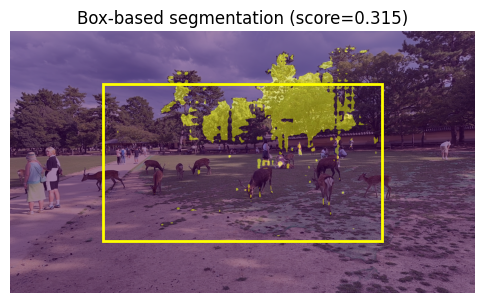

In [12]:
# Cell: Box-based segmentation example
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 1) 读取并设置图像（以 deer.jpg 为例）
img_file = IMAGE_DIR / "deer.jpg"
img = np.array(Image.open(img_file))
predictor.set_image(img)

# 2) 定义提示框 [x0, y0, x1, y1]
#    下面是一个示例框，围住画面中央区域
h, w = img.shape[:2]
box = np.array([[w*0.2, h*0.2, w*0.8, h*0.8]])  # 根据需要改为整数坐标

# 3) 调用 predict
masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=box,                
    multimask_output=False  
)

# 4) 可视化分割结果
mask = masks[0]
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.imshow(mask, alpha=0.5)
# 画出提示框
x0, y0, x1, y1 = box[0]
plt.gca().add_patch(plt.Rectangle((x0, y0), x1-x0, y1-y0, 
                                  fill=False, edgecolor='yellow', linewidth=2))
plt.axis('off')
plt.title(f"Box-based segmentation (score={scores[0]:.3f})")
plt.show()


### 多结果（multimask_output=True）示例

Generated 3 masks, scores: ['0.920', '0.791', '0.764']


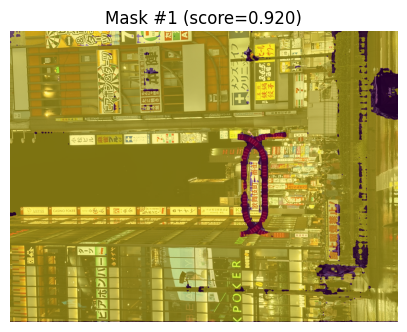

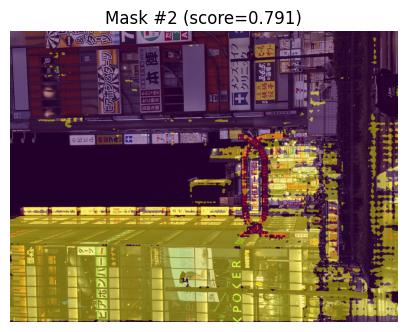

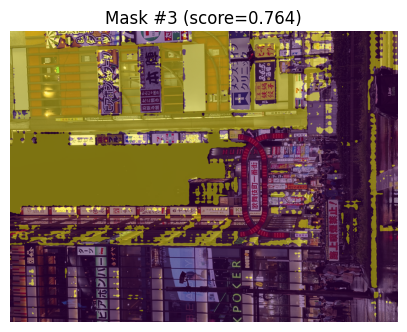

In [13]:
# Cell: Multi-mask segmentation example
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 1) 读取并设置图像
img_file = IMAGE_DIR / "japan.jpg"
img = np.array(Image.open(img_file))
predictor.set_image(img)

# 2) 定义提示：这里继续用一个大框
h, w = img.shape[:2]
box = np.array([[0, 0, w-1, h-1]])

# 3) 调用 predict，打开 multi-mask
masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=box,
    multimask_output=True   # 允许输出多个 mask
)

# masks.shape -> (3, H, W)，scores 长度也是 3
print("Generated", masks.shape[0], "masks, scores:", [f"{s:.3f}" for s in scores])

# 4) 可视化每一种 mask
for i, (mask, score) in enumerate(zip(masks, scores), start=1):
    plt.figure(figsize=(5,5))
    plt.title(f"Mask #{i} (score={score:.3f})")
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5)
    plt.axis('off')
    plt.show()


### 混合提示（Box + Point）分割示例

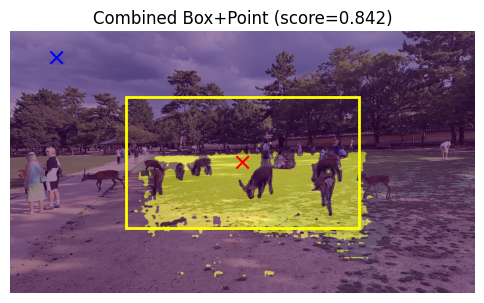

In [14]:
# Cell: Combined box + point segmentation
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 1) 读取并设置图像
img_file = IMAGE_DIR / "deer.jpg"
img = np.array(Image.open(img_file))
predictor.set_image(img)

# 2) 定义提示框和点
h, w = img.shape[:2]
# 框提示：大致圈出场景中心
box = np.array([[w*0.25, h*0.25, w*0.75, h*0.75]])

# 点提示：提供一个前景点和一个背景点
# 前景点（标签为1）：在鹿身上
fg_point = [int(w*0.5), int(h*0.5)]
# 背景点（标签为0）：在鹿以外的区域
bg_point = [int(w*0.1), int(h*0.1)]
point_coords = np.array([fg_point, bg_point])
point_labels = np.array([1, 0])

# 3) 调用 predict
masks, scores, logits = predictor.predict(
    point_coords=point_coords,
    point_labels=point_labels,
    box=box,
    multimask_output=False
)

# 4) 可视化结果
mask = masks[0]
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.imshow(mask, alpha=0.5)
# 画出提示框
x0, y0, x1, y1 = box[0]
plt.gca().add_patch(plt.Rectangle((x0, y0), x1-x0, y1-y0, 
                                  fill=False, edgecolor='yellow', linewidth=2))
# 画出点提示
plt.scatter(point_coords[:,0], point_coords[:,1], 
            c=['r' if lab==1 else 'b' for lab in point_labels], 
            s=80, marker='x')
plt.axis('off')
plt.title(f"Combined Box+Point (score={scores[0]:.3f})")
plt.show()


### 使用 AutomaticMaskGenerator 自动生成候选掩码

In [17]:
sam_cpu = sam.to("cpu")
mask_generator = SamAutomaticMaskGenerator(sam_cpu)
automatic_masks = mask_generator.generate(img)


Generated 54 masks


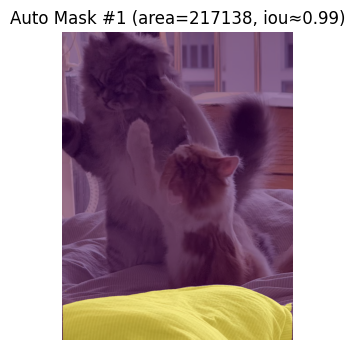

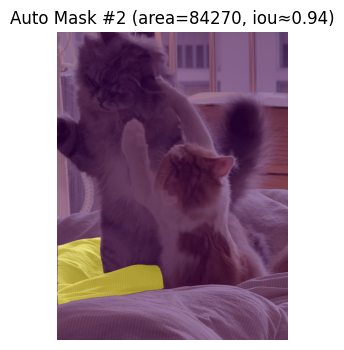

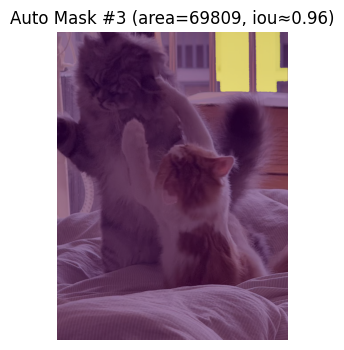

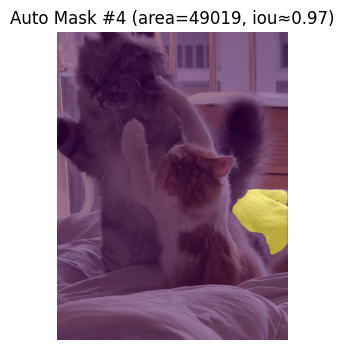

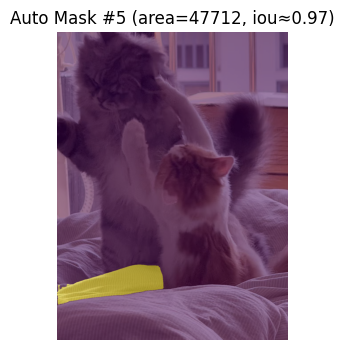

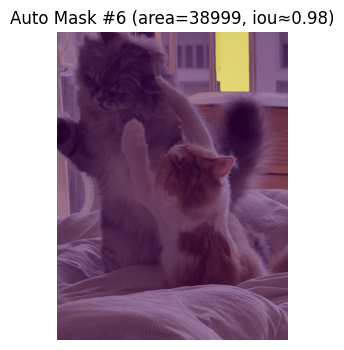

In [18]:
# Cell: Automatic mask generation (no prompts)
from segment_anything import SamAutomaticMaskGenerator

# 1) 用之前加载好的 sam（同一个模型）构造生成器
mask_generator = SamAutomaticMaskGenerator(sam)

# 2) 读取并设置图像（以 cat.jpg 为例）
img = np.array(Image.open(IMAGE_DIR / "cat.jpg"))

# 3) 生成所有掩码
automatic_masks = mask_generator.generate(img)
print(f"Generated {len(automatic_masks)} masks")

# 4) 可视化前 6 个高置信度掩码
for i, m in enumerate(sorted(automatic_masks, key=lambda x: x['area'], reverse=True)[:6], start=1):
    mask = m['segmentation']  # bool 数组
    score = m.get('predicted_iou', 0)
    
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5)
    plt.axis('off')
    plt.title(f"Auto Mask #{i} (area={m['area']}, iou≈{score:.2f})")
    plt.show()


### 自定义自动掩码生成器参数并保存所有掩码

After filtering, generated 94 masks
Saved mask #0 → cat_auto_00_iou1.00.png
Saved mask #1 → cat_auto_01_iou0.99.png
Saved mask #2 → cat_auto_02_iou0.99.png
Saved mask #3 → cat_auto_03_iou0.99.png
Saved mask #4 → cat_auto_04_iou0.99.png
Saved mask #5 → cat_auto_05_iou0.99.png
Saved mask #6 → cat_auto_06_iou0.99.png
Saved mask #7 → cat_auto_07_iou0.99.png
Saved mask #8 → cat_auto_08_iou0.99.png
Saved mask #9 → cat_auto_09_iou0.99.png
Saved mask #10 → cat_auto_10_iou0.98.png
Saved mask #11 → cat_auto_11_iou0.98.png
Saved mask #12 → cat_auto_12_iou0.98.png
Saved mask #13 → cat_auto_13_iou0.98.png
Saved mask #14 → cat_auto_14_iou0.98.png
Saved mask #15 → cat_auto_15_iou0.98.png
Saved mask #16 → cat_auto_16_iou0.98.png
Saved mask #17 → cat_auto_17_iou0.98.png
Saved mask #18 → cat_auto_18_iou0.97.png
Saved mask #19 → cat_auto_19_iou0.97.png
Saved mask #20 → cat_auto_20_iou0.97.png
Saved mask #21 → cat_auto_21_iou0.97.png
Saved mask #22 → cat_auto_22_iou0.97.png
Saved mask #23 → cat_auto_23_io

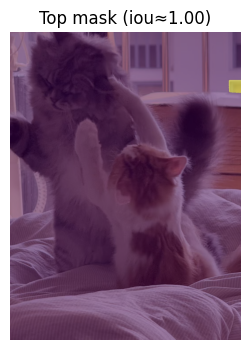

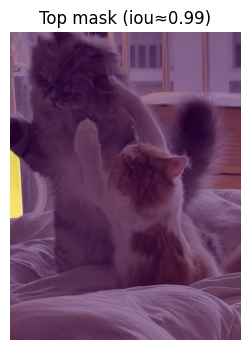

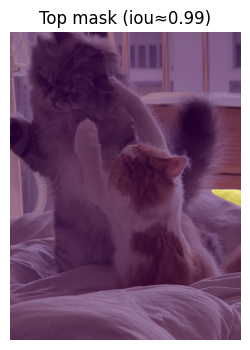

In [20]:
# Cell: Custom automatic mask generation & saving (fixed parameters)
from segment_anything import SamAutomaticMaskGenerator
from PIL import Image
import numpy as np

# 1) 将模型放到 CPU（或直接用 MPS 都行）
sam_cpu = sam.to("cpu")

# 2) 构造带自定义参数的生成器
mask_generator = SamAutomaticMaskGenerator(
    sam_cpu,
    pred_iou_thresh=0.8,            # 只保留预测 IoU ≥ 0.8 的掩码
    stability_score_thresh=0.8,     # 只保留稳定性分数 ≥ 0.8
    box_nms_thresh=0.7,             # 掩码间 NMS 阈值
    # 你也可以加 crop_n_layers, points_per_batch 等参数
)

# 3) 读取并转换图像
img = np.array(Image.open(IMAGE_DIR / "cat.jpg")).astype(np.float32)

# 4) 生成掩码列表
automatic_masks = mask_generator.generate(img)
print(f"After filtering, generated {len(automatic_masks)} masks")

# 5) 批量保存所有掩码到 outputs/
for i, m in enumerate(automatic_masks):
    mask = m["segmentation"]
    score = m.get("predicted_iou", 0)
    out_path = OUTPUT_DIR / f"cat_auto_{i:02d}_iou{score:.2f}.png"
    Image.fromarray((mask * 255).astype(np.uint8)).save(out_path)
    print(f"Saved mask #{i} → {out_path.name}")

# 6) （可选）展示前 3 个最高置信度掩码
import matplotlib.pyplot as plt
for m in sorted(automatic_masks, key=lambda x: x["predicted_iou"], reverse=True)[:3]:
    plt.figure(figsize=(4,4))
    plt.imshow(img.astype(np.uint8))
    plt.imshow(m["segmentation"], alpha=0.5)
    plt.axis("off")
    plt.title(f"Top mask (iou≈{m['predicted_iou']:.2f})")
    plt.show()
